In this example, we will use matrix Lie maps for simple and well known dynamic systems simulation. We also will compare simulation results with traditional numerical integration.

In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from utils import load_Lie_weights

Using TensorFlow backend.


Let's define pre-built maps for three well-known systems. We used time interval 0.001 for the Lotka--Volterra equation and the Van der Pole oscillator, and time interval 0.1 for the Hénon–Heiles system.

In [2]:
#saddle point:
W_saddle = [np.array([[0.], [0.]]).T,
            np.array([[1.00504925, 0.00500008],
                      [0.01500024, 0.99504909]]).T,
            np.array([[0., 0., 0., 0.],
                      [0., 0., 0., 0.]]).T,
            np.array([[0., 0., 0., 0., 0.,0.,0., 0.],
                      [0., 0., 0., 0., 0.,0.,0., 0.]]).T]

# Lotka–Volterra system:
W_lotka = [np.array([[0.], [0.]]).T,
           np.array([[ 0.99995083, -0.00999984],
                     [ 0.00999984,  0.99995083]]).T,
           np.array([[-4.93234735e-05, -1.00483639e-02, 0.,  4.93234735e-05],
                     [4.90059809e-05,  9.95003443e-03, 0., -4.90059809e-05]]).T,
           np.array([[-1.57554152e-07, -4.86756047e-05, 0.,  4.99627671e-05, 0.,0.,0., -1.60680362e-07],
                     [ 1.56801572e-07,  4.83612053e-05, 0., -4.96422137e-05, 0.,0.,0.,  1.59915934e-07]]).T]
# Van der Pole oscillator:
W_pole = [np.array([[0.], [0.]]).T,
          np.array([[ 0.99995067,  0.01004917],
                    [-0.01004917,  1.00999984]]).T,
          np.array([[0., 0., 0., 0.],
                    [0., 0., 0., 0.]]).T,
          np.array([[ 1.59504733e-07, -4.94822066e-05, 0., -3.20576750e-07, 0.,0.,0., -7.90629025e-10],
                    [ 4.94821629e-05, -1.00975145e-02, 0., -9.96173322e-05, 0.,0.,0., -3.30168067e-07]]).T]

# Hénon–Heiles system
W_henon = load_Lie_weights('data/henon.txt', 4)
for w in W_henon:
    print w.shape

('load weights: ', 'data/henon.txt')
start converting
(1,)
start converting
(4,)
start converting
(16,)
start converting
(64,)
start converting
(256,)
(1, 4)
(4, 4)
(16, 4)
(64, 4)
(256, 4)


Then load this matrices into polynomial neural network:

In [3]:
order = 3 # 3rd order of nonlinearity
dim = 2 # two-dimension state vector

# neural network representation of saddle point
map_saddle = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
model_saddle = Sequential()
model_saddle.add(map_saddle)
map_saddle.set_weights(W_saddle)

# neural network representation of Lotka-Voltera system
map_lotka = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
model_lotka = Sequential()
model_lotka.add(map_lotka)
map_lotka.set_weights(W_lotka)

# neural network representation of Van der Pole oscillator
map_pole = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
model_pole = Sequential()
model_pole.add(map_pole)
map_pole.set_weights(W_pole)

# neural network representation of Hénon–Heiles system
map_henon = LieLayer(output_dim = dim*2, order = order+1, input_shape = (dim*2,))
model_henon = Sequential()
model_henon.add(map_henon)
map_henon.set_weights(W_henon)

Instructions for updating:
Colocations handled automatically by placer.


Now we can simply simulate our model via polynomial neural network prediction, as well as compare the results with Runge-Kutta integration. To start the simulation with neural network one needs just iteratively predict points step-by step

In [4]:
def nn_predict(model, X0, epoch_n):
    X = []
    X.append(X0)
    for i in xrange(epoch_n):
        X.append(model.predict(X[-1]))

    return np.array(X)

X0_saddle = np.array([[-1, 2],
                      [-0.5, 2.5],
                      [0.5, -2.5],
                      [1, -2],], dtype=float).reshape((-1, dim))

X0_lotka = np.array([[0, 0.05],
                     [0, 0.15],
                     [0, 0.3]], dtype=float).reshape((-1, dim))

X0_pole = np.array([[1, 2],
                    [2, -2],
                    [-3, -3],
                    [-2, 4]], dtype=float).reshape((-1, dim))
X0_henon = np.array([[0, 0.67, 0.093, 0],], dtype=float).reshape((-1, 2*dim))

X_nn_saddle = nn_predict(model_saddle, X0_saddle, epoch_n=200)
X_nn_lotka = nn_predict(model_lotka, X0_lotka, epoch_n=700)
X_nn_pole = nn_predict(model_pole, X0_pole, epoch_n=700)

To compare the results with traditional numerical integration one should define equations and use an ode-solver

In [5]:
from scipy.integrate import solve_ivp

def saddle_system(t, state): # right-hand side of a system of ODEs
    x = state[0]
    y = state[1]
    p=0
    q=-1
    A = 0.5
    B = 0.5
    D = p-A
    C = (A*D - q)/B
    return np.array([A*x+B*y, C*x+D*y])


def lotka_system(t, state): # right-hand side of a system of ODEs
    x = state[0]
    y = state[1]
    return np.array([-y-x*y, x+x*y])


def pole_system(t, state): # right-hand side of a system of ODEs
    x = state[0]
    dx= state[1]
    return np.array([dx, dx-x*x*dx - x])


def henon_system(t, state): # right-hand side of a system of ODEs
    q1 = state[0]
    q2 = state[1]
    p1 = state[2]
    p2 = state[3]
    return np.array([p1, p2, -q1-2*q1*q2, -q2-q1**2+q2**2])


def integrate(f, X0, epoch_n, h=0.001, N=10):
    t = h*N*epoch_n
    X = []
    for state0 in X0:
        sol = solve_ivp(f, [0, t], state0, max_step=0.1)
        X.append(sol.y)
    return X


X_rk_saddle = integrate(saddle_system, X0_saddle, epoch_n=200)
X_rk_lotka = integrate(lotka_system, X0_lotka, epoch_n=700)
X_rk_pole = integrate(pole_system, X0_pole, epoch_n=700)

Now we can compare simulation by Lie transform-based neural network and traditional numerical integration

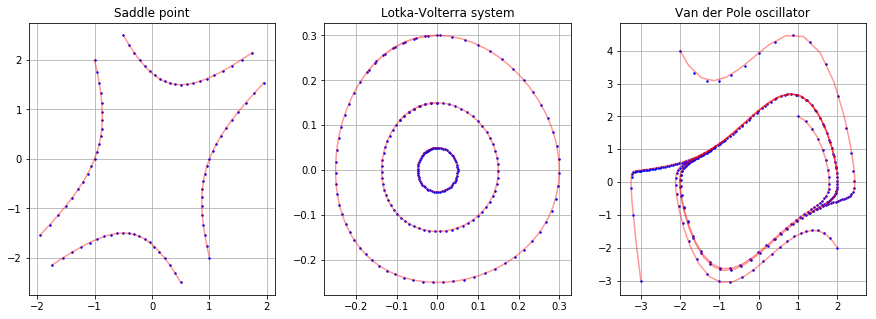

In [6]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)


# plot simulation by neural network 
for i, X_nn in enumerate([X_nn_saddle, X_nn_lotka, X_nn_pole]):
    ax[i].plot(X_nn[::10,:,0], X_nn[::10,:,1], 'b.', markersize=3)


# plot simulation by traditional numerical method
for i, X_rk in enumerate([X_rk_saddle, X_rk_lotka, X_rk_pole]):
    for x in X_rk:
        ax[i].plot(x[0, :], x[1, :], 'r-', alpha = 0.4)
    ax[i].grid()

ax[0].set_title('Saddle point')
ax[1].set_title('Lotka-Volterra system')
ax[2].set_title('Van der Pole oscillator')
plt.show()

In [13]:
# simulation of dynamical chaos
X_nn_henon = nn_predict(model_henon, X0_henon, epoch_n=50000)
X_rk_henon = integrate(henon_system, X0_henon, epoch_n=50000, h=0.1, N=1)

(50001, 1, 4)


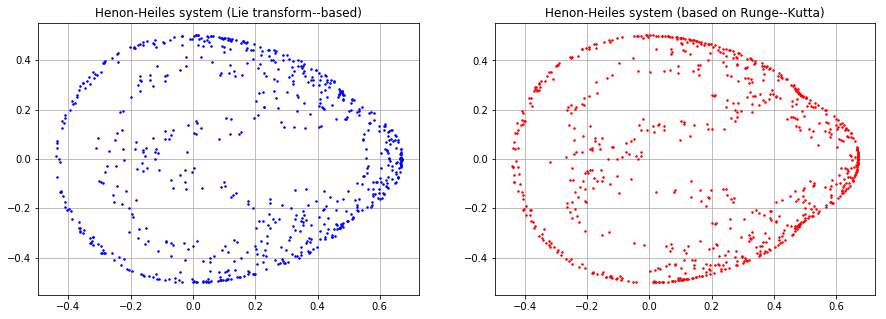

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

print X_nn_henon.shape

poincar_map = np.abs(X_nn_henon[:,:,0]) <= 0.005
ax[0].plot(X_nn_henon[poincar_map, 1], X_nn_henon[poincar_map, 3], 'b.', markersize=3)

for x in X_rk_henon:
    poincar_map = np.abs(x[0, :]) <= 0.005
    ax[1].plot(x[1, poincar_map], x[3, poincar_map], 'r.', markersize=3)
    
for i in [0,1]:
    ax[i].grid()
ax[0].set_title('Henon-Heiles system (Lie transform--based)')
ax[1].set_title('Henon-Heiles system (based on Runge--Kutta)')

plt.show()